In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from sklearn import preprocessing # https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities
from snowflake.snowpark.functions import col

import getpass
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
accountname = 'nj07294.ap-southeast-1'
#accountname = getpass.getpass() # ORGNAME-ACCOUNTNAME (separated by minus sign)

In [3]:
username = getpass.getpass()    # SNOWFLAKE-USERNAME

In [4]:
password = getpass.getpass()    # SNOWFLAKE-PASSWORD

In [5]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "FROSTBYTE_TASTY_BYTES",

    "warehouse": "HOL_WH"
}

session = Session.builder.configs(connection_parameters).create()

In [6]:
session.use_schema("ANALYTICS")
X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()

In [7]:
X_final_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540201 entries, 0 to 540200
Data columns (total 38 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   TRUCK_ID                                  540201 non-null  int8   
 1   MONTH                                     540201 non-null  int8   
 2   HOUR                                      540201 non-null  int8   
 3   DOW                                       540201 non-null  int8   
 4   DAY                                       540201 non-null  int8   
 5   PUBLIC_HOLIDAY                            540201 non-null  int8   
 6   Profit                                    540201 non-null  float64
 7   LAT                                       540201 non-null  float64
 8   LONG                                      540201 non-null  float64
 9   LOCATION_ID                               540201 non-null  int16  
 10  SUM_DAY_OF_WEEK_AVG_

In [8]:
X_final_scaled.head()

,TRUCK_ID,MONTH,HOUR,DOW,DAY,PUBLIC_HOLIDAY,Profit,LAT,LONG,LOCATION_ID,...,CITY_SEATTLE_ENCODED,CITY_DENVER_ENCODED,CITY_San Mateo_encoded,CITY_New York City_encoded,CITY_BOSTON_ENCODED,REGION_NY_ENCODED,REGION_MA_ENCODED,REGION_CO_ENCODED,REGION_WA_ENCODED,REGION_CA_ENCODED
0,68,7,8,6,10,0,10027.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
1,68,7,9,6,10,0,17477.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
2,68,7,10,6,10,0,13992.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
3,68,7,11,6,10,0,17616.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0
4,68,7,12,6,10,0,15415.0,40.768807,-73.985856,3007,...,0,0,0,1,0,1,0,0,0,0


In [9]:
print(X_final_scaled.columns.tolist())

['TRUCK_ID', 'MONTH', 'HOUR', 'DOW', 'DAY', 'PUBLIC_HOLIDAY', 'Profit', 'LAT', 'LONG', 'LOCATION_ID', 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', 'WEATHERCODE', 'MENU_TYPE_GYROS_ENCODED', 'MENU_TYPE_CREPES_ENCODED', 'MENU_TYPE_BBQ_ENCODED', 'MENU_TYPE_SANDWICHES_ENCODED', 'MENU_TYPE_Mac & Cheese_encoded', 'MENU_TYPE_POUTINE_ENCODED', 'MENU_TYPE_ETHIOPIAN_ENCODED', 'MENU_TYPE_TACOS_ENCODED', 'MENU_TYPE_Ice Cream_encoded', 'MENU_TYPE_Hot Dogs_encoded', 'MENU_TYPE_CHINESE_ENCODED', 'MENU_TYPE_Grilled Cheese_encoded', 'MENU_TYPE_VEGETARIAN_ENCODED', 'MENU_TYPE_INDIAN_ENCODED', 'MENU_TYPE_RAMEN_ENCODED', 'CITY_SEATTLE_ENCODED', 'CITY_DENVER_ENCODED', 'CITY_San Mateo_encoded', 'CITY_New York City_encoded', 'CITY_BOSTON_ENCODED', 'REGION_NY_ENCODED', 'REGION_MA_ENCODED', 'REGION_CO_ENCODED', 'REGION_WA_ENCODED', 'REGION_CA_ENCODED']


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Split the dataset into features (X) and target (y)
X = X_final_scaled.drop("Profit",axis=1)
y = X_final_scaled["Profit"]

# Split the dataset into training and testing datasets
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
import seaborn as sns
import scipy.stats as stats

In [12]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
xgb = LGBMRegressor(n_estimators=500)
xgb.fit(X_train, y_train)
print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

Train MSE is:  2968953.9094878756
Test MSE is:  3260824.369489615

Train RMSE is:  1723.065265591491
Test RMSE is:  1805.7752821128145

Train MAE is:  1163.5308455133852
Test MAE is:  1198.4530543854682

Train R2 is:  0.9071514900595083
Test R2 is:  0.8982355271341209


In [13]:
# Create a DataFrame with holdout values and predicted values
df_predictions = X_holdout.copy()
df_predictions['Holdout'] = y_holdout
holdout_predictions = xgb.predict(X_holdout)
df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Print the DataFrame
print(df_predictions)

        TRUCK_ID  MONTH  HOUR  DOW  DAY  PUBLIC_HOLIDAY        LAT  \
58027         50      5    10    1    9               0  42.247702   
386383        33      3    10    3   16               0  47.605014   
211458        45      7    17    5    1               0  47.588769   
455709        75     11    18    6   13               0  40.710351   
342396        42      5    11    6   14               0  47.575333   
...          ...    ...   ...  ...  ...             ...        ...   
209115        20      3    11    1   21               0  39.750623   
510853         3     10    13    5    7               0  37.557758   
199755        41     10     9    6   23               0  47.628276   
330459        33      8    17    2   31               0  47.526835   
256006        50     11    19    0    8               0  42.303791   

              LONG  LOCATION_ID  SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE  ...  \
58027   -71.129438        15284                           -0.372952  ...   
386383 

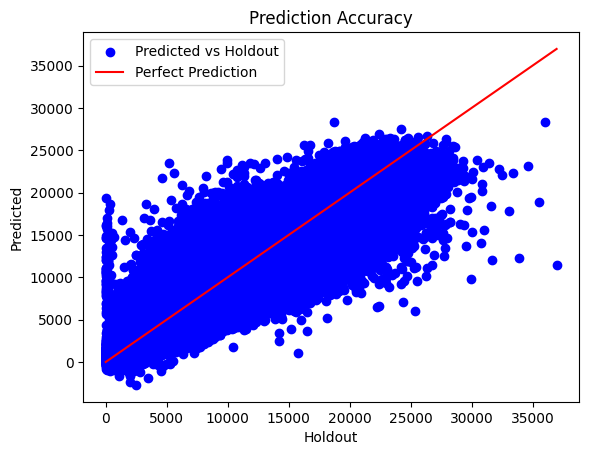

In [77]:
import matplotlib.pyplot as plt

# Plot the predicted values against the holdout values
plt.scatter(df_predictions['Holdout'], df_predictions['Predicted'], c='blue', label='Predicted vs Holdout')

# Add a reference line
plt.plot([df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], [df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], c='red', label='Perfect Prediction')

# Set labels and title
plt.xlabel('Holdout')
plt.ylabel('Predicted')
plt.title('Prediction Accuracy')

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [78]:
# Get unique location IDs
unique_location_ids = df_predictions['LOCATION_ID'].unique()
print("Unique Location IDs:", unique_location_ids)

# Create a list to store the table data
table_data = []


# Create a DataFrame to store the table data
df_unique_locations_lat_long = pd.DataFrame(columns=["Location ID", "Latitude", "Longitude"])

# Iterate over each unique location ID
for location_id in unique_location_ids:
    location = df_predictions[df_predictions['LOCATION_ID'] == location_id]
    latitude = location['LAT'].values[0]
    longitude = location['LONG'].values[0]
    df_unique_locations_lat_long = pd.concat([df_unique_locations_lat_long, pd.DataFrame({"Location ID": [location_id],
                                                  "Latitude": [latitude],
                                                  "Longitude": [longitude]})],
                         ignore_index=True)

    

# Print the DataFrame
df_unique_locations_lat_long

Unique Location IDs: [15284  1675 15088 ... 15085 14897  3651]


,Location ID,Latitude,Longitude
0,15284,42.247702,-71.129438
1,1675,47.605014,-122.336302
2,15088,47.588769,-122.380905
3,4135,40.710351,-74.010756
4,5173,47.575333,-122.416758
...,...,...,...
1873,10893,40.800868,-73.959873
1874,2414,47.612053,-122.312236
1875,15085,47.563518,-122.404177
1876,14897,39.689947,-104.997897


In [79]:
import math
import pandas as pd

def calculate_distances(df_predictions, starting_location_id):
    def haversine_distance(lat1, lon1, lat2, lon2):
        # Convert latitude and longitude from degrees to radians
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)

        # Haversine formula
        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad
        a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = 6371 * c  # Radius of the Earth in kilometers
        return distance

    # Find the reference location based on the starting location ID
    reference_location = df_predictions[df_predictions['LOCATION_ID'] == starting_location_id]
    reference_latitude = reference_location['LAT'].values[0]
    reference_longitude = reference_location['LONG'].values[0]

    # List of other locations with their respective location IDs, latitudes, and longitudes
    other_locations = df_predictions[['LOCATION_ID', 'LAT', 'LONG']].drop_duplicates().values.tolist()

    # Calculate distances between starting location and other locations
    distances = []
    for location in other_locations:
        location_id = location[0]
        latitude = location[1]
        longitude = location[2]
        distance = haversine_distance(reference_latitude, reference_longitude, latitude, longitude)
        distances.append({'Location_ID_start': starting_location_id, 'Location_ID_end': location_id, 'distance': distance})

    # Create a DataFrame from the distances list
    df_distances = pd.DataFrame(distances)

    # Sort the DataFrame by distance in ascending order
    df_distances = df_distances.sort_values('distance')

    return df_distances

# Example usage
reference_location_id = 5176
df_distances = calculate_distances(df_predictions, reference_location_id)
print(f"Distances from Location ID {reference_location_id}:")
df_distances


Distances from Location ID 5176:


,Location_ID_start,Location_ID_end,distance
500,5176,5176.0,0.000000
506,5176,2762.0,0.926345
208,5176,3003.0,0.963089
1113,5176,5174.0,1.191913
1649,5176,15086.0,1.195572
...,...,...,...
1167,5176,3731.0,4010.418755
1636,5176,15226.0,4013.935552
1298,5176,15221.0,4015.038004
42,5176,5236.0,4015.471760


In [80]:
import numpy as np

# Specify the criteria for filtering
truck_id = 43
month = 8
day = 25

columns_to_exclude = ['AVG_TEMPERATURE_AIR_2M_F', 'AVG_TEMPERATURE_HEATINDEX_2M_F', 'TOT_PRECIPITATION_IN', 'TOT_SNOWFALL_IN', 'TOT_SNOWDEPTH_IN', 'AVG_CLOUD_COVER_TOT_PCT']

# Create a DataFrame with holdout values and predicted values
df_predictions = X_final_scaled.drop("Profit",axis=1)
holdout_predictions = xgb.predict(df_predictions)
df_predictions['Holdout'] = X_final_scaled[["Profit"]]

df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Filter the DataFrame for the specified criteria
filtered_df = df_predictions[(df_predictions['TRUCK_ID'] == truck_id) &
                             (df_predictions['MONTH'] == month) &
                             (df_predictions['DAY'] == day)]

# Sort the DataFrame by HOUR and Predicted values
sorted_df = filtered_df.sort_values(['HOUR', 'Predicted'], ascending=[True, False])

# Initialize a list to hold the table rows
table_rows = []

# Loop through each hour
for hour in sorted_df['HOUR'].unique():
    # Filter the DataFrame for the current hour
    hour_df = sorted_df[sorted_df['HOUR'] == hour]

    # Get the holdout values, predicted values, and best location ID for the current hour
    holdout_values = hour_df['Holdout'].tolist()
    predicted_values = hour_df['Predicted'].tolist()
    best_location_id = hour_df['LOCATION_ID'].iloc[0]

    # Filter distances DataFrame for distances less than 4 km from location_id 5176.0
    filtered_distances = df_distances[(df_distances['Location_ID_start'] == 5176.0) & (df_distances['distance'] < 4.0)]

    # Get the possible location IDs including the newly added location IDs
    possible_location_ids = sorted(set(hour_df['LOCATION_ID'].unique()) | set(filtered_distances['Location_ID_end'].unique()))

    # Initialize a list to hold the predicted values for each possible location ID
    predicted_values_per_location = []

    # Loop through each possible location ID
    for location_id_end in possible_location_ids:
        # Filter the DataFrame for the current location ID
        location_df = hour_df[hour_df['LOCATION_ID'] == location_id_end]

        # If there are records for the current location ID, append the predicted value
        if not location_df.empty:
            predicted_value = location_df['Predicted'].iloc[0]
        else:
            predicted_value = 0  # Default predicted value if no records exist for the current location ID

        predicted_values_per_location.append(predicted_value)

    # Append the row to the table_rows list
    table_rows.append([hour, best_location_id, possible_location_ids, holdout_values, predicted_values, predicted_values_per_location])

# Create a DataFrame from the table_rows list
df_best_loc_id = pd.DataFrame(table_rows, columns=["Hour", "Best Location ID", "Possible Location IDs", "Holdout Values", "Predicted Values", "Predicted Values per Location"])


In [81]:
import numpy as np

# Specify the criteria for filtering
truck_id = 43
month = 8
day = 25

# Create a DataFrame with holdout values and predicted values
df_predictions = X_final_scaled.drop("Profit",axis=1)
holdout_predictions = xgb.predict(df_predictions)
df_predictions['Holdout'] = X_final_scaled[["Profit"]]

df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

# Filter the DataFrame for the specified criteria
filtered_df = df_predictions[(df_predictions['TRUCK_ID'] == truck_id) &
                             (df_predictions['MONTH'] == month) &
                             (df_predictions['DAY'] == day)]


# Sort the DataFrame by HOUR and Predicted values
sorted_df = filtered_df.sort_values(['HOUR', 'Predicted'], ascending=[True, False])

# Initialize a list to hold the table rows
table_rows = []

# Filter distances DataFrame for distances less than 4 km from location_id 5176.0
filtered_distances = df_distances[(df_distances['Location_ID_start'] == 5176.0) & (df_distances['distance'] < 4.0)]

# Get unique location IDs from the filtered distances DataFrame
all_location_ids = filtered_distances['Location_ID_end'].unique()

# Loop through each hour
for hour in sorted_df['HOUR'].unique():
    # Filter the DataFrame for the current hour
    hour_df = sorted_df[sorted_df['HOUR'] == hour]

    # Duplicate rows for each possible location ID
    duplicated_df = hour_df.loc[hour_df.index.repeat(len(all_location_ids))]
    duplicated_df['LOCATION_ID'] = np.tile(all_location_ids, len(hour_df))

    # Select only the relevant features for prediction
    X_new = duplicated_df.drop(columns=['Difference', 'Holdout', 'Predicted'])

    # Predict on the new rows with possible location IDs
    new_predictions = xgb.predict(X_new)
    duplicated_df['Predicted'] = new_predictions

    # Loop through each row in the duplicated DataFrame
    for _, row in duplicated_df.iterrows():
        # Get the location ID, holdout values, and predicted values for the current row
        location_id = row['LOCATION_ID']
        holdout_values = row['Holdout']
        predicted_values = row['Predicted']

        # Append the row to the table_rows list
        table_rows.append([hour, location_id, holdout_values, predicted_values])

# Create a DataFrame from the table_rows list
df_predictions_per_hour_location = pd.DataFrame(table_rows, columns=["Hour", "Location ID", "Holdout Values", "Predicted Values"])

In [82]:
import pandas as pd

pd.options.mode.chained_assignment = None

# Create a new DataFrame to store all rows for location_df
Best_loc_df = pd.DataFrame()

# Loop through each hour
for hour in df_predictions_per_hour_location['Hour'].unique():
    print(f"Hour: {hour}")

    # Filter the DataFrame for the current hour
    hour_df = df_predictions_per_hour_location[df_predictions_per_hour_location['Hour'] == hour]

    # Loop through each location ID
    for location_id in hour_df['Location ID'].unique():
        # Filter the DataFrame for the current hour and location ID
        location_df = hour_df[hour_df['Location ID'] == location_id]

        # Calculate the average predicted value for the current hour and location ID
        average_predicted_value = location_df['Predicted Values'].mean()

        # Update the location_df with the mean predicted values
        location_df.loc[:, 'Average Predicted Value'] = average_predicted_value

        # Append the rows for location_df to the all_rows_df DataFrame
        Best_loc_df = pd.concat([Best_loc_df, location_df])

        print(f"Location ID: {location_id}, Average Predicted Value: {average_predicted_value}")

pd.options.mode.chained_assignment = 'warn'

Hour: 8
Location ID: 5176.0, Average Predicted Value: 5831.2177734375
Location ID: 2762.0, Average Predicted Value: 5665.31982421875
Location ID: 3003.0, Average Predicted Value: 5850.18408203125
Location ID: 5174.0, Average Predicted Value: 5831.2177734375
Location ID: 15086.0, Average Predicted Value: 6014.43896484375
Location ID: 2272.0, Average Predicted Value: 6202.61572265625
Location ID: 15096.0, Average Predicted Value: 6062.721435546875
Location ID: 15097.0, Average Predicted Value: 6095.294921875
Location ID: 2294.0, Average Predicted Value: 6127.24658203125
Location ID: 15081.0, Average Predicted Value: 6004.647216796875
Location ID: 15095.0, Average Predicted Value: 6187.1767578125
Location ID: 15088.0, Average Predicted Value: 6006.177001953125
Location ID: 3673.0, Average Predicted Value: 5939.949951171875
Location ID: 15079.0, Average Predicted Value: 6004.647216796875
Location ID: 15083.0, Average Predicted Value: 6038.03759765625
Location ID: 1088.0, Average Predicted 

In [83]:
# Loop through each hour
for hour in Best_loc_df['Hour'].unique():
    print(f"Hour: {hour}")

    # Filter the DataFrame for the current hour
    hour_df = Best_loc_df[Best_loc_df['Hour'] == hour]

    # Find the location with the largest average predicted value for the current hour
    max_avg_predicted = hour_df['Average Predicted Value'].max()
    best_location_id = hour_df.loc[hour_df['Average Predicted Value'] == max_avg_predicted, 'Location ID'].values[0]

    print(f"Location ID: {best_location_id}, Largest Average Predicted Value: {max_avg_predicted}")

    print()

Hour: 8
Location ID: 2272.0, Largest Average Predicted Value: 6202.61572265625

Hour: 9
Location ID: 15095.0, Largest Average Predicted Value: 10866.427734375

Hour: 10
Location ID: 15095.0, Largest Average Predicted Value: 6266.705078125

Hour: 11
Location ID: 3003.0, Largest Average Predicted Value: 6728.6572265625

Hour: 12
Location ID: 2762.0, Largest Average Predicted Value: 10058.880859375

Hour: 13
Location ID: 2762.0, Largest Average Predicted Value: 7257.961181640625

Hour: 14
Location ID: 2272.0, Largest Average Predicted Value: 2201.48291015625

Hour: 15
Location ID: 2762.0, Largest Average Predicted Value: 2435.0209147135415

Hour: 16
Location ID: 2762.0, Largest Average Predicted Value: 3948.0100911458335

Hour: 17
Location ID: 2762.0, Largest Average Predicted Value: 8001.292643229167

Hour: 18
Location ID: 15095.0, Largest Average Predicted Value: 10342.8857421875

Hour: 19
Location ID: 15095.0, Largest Average Predicted Value: 11444.949869791666

Hour: 20
Location ID: 1

In [84]:
Best_loc_df = Best_loc_df.drop_duplicates()
Best_loc_df.head()

,Hour,Location ID,Holdout Values,Predicted Values,Average Predicted Value
0,8,5176.0,2014.0,5974.411621,5831.217773
40,8,5176.0,6776.0,5688.023926,5831.217773
1,8,2762.0,2014.0,6085.344727,5665.319824
41,8,2762.0,6776.0,5245.294922,5665.319824
2,8,3003.0,2014.0,6276.187500,5850.184082


In [86]:
import matplotlib.pyplot as plt

x_values = []
y_values = []
holdout_values = []
new_values = []
colors = []

previous_location_id = 5176

# Loop through each hour
for hour in Best_loc_df['Hour'].unique():
    print(f"Hour: {hour}")

    # Filter the DataFrame for the current hour
    hour_df = Best_loc_df[Best_loc_df['Hour'] == hour]

    # Find the location with the largest average predicted value for the current hour
    max_avg_predicted = hour_df['Average Predicted Value'].max()
    best_location_id = hour_df.loc[hour_df['Average Predicted Value'] == max_avg_predicted, 'Location ID'].values[0]

    print(f"Location ID: {best_location_id}, New Value gained: {max_avg_predicted}")

    # # Get the corresponding holdout value for the best location
    holdout_value = filtered_df.loc[(filtered_df['LOCATION_ID'] == previous_location_id) & (filtered_df['HOUR'] == hour), 'Holdout']

    print(f"Holdout Value: {holdout_value}")

    additional_value = max_avg_predicted - holdout_value.values[0]
    
    print(type(additional_value), type(holdout_value), type(max_avg_predicted))
    print(f"Additional Value: {additional_value}")

    # Append the hour and additional value to the x and y value lists
    x_values.append(hour)
    y_values.append(additional_value)

    # Append the holdout value and new value to the respective lists
    holdout_values.append(holdout_value)
    new_values.append(max_avg_predicted)

    # Check if the location has changed and assign colors accordingly
    if best_location_id == 5176:
        colors.append('red')
    else:
        colors.append('green')

    # Display the numerical value as annotation
    plt.annotate(f'{additional_value:.2f}', (hour, additional_value), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=8)

# Plot the values
plt.scatter(x_values, y_values, c=colors, label='Additional Value')
plt.plot(x_values, holdout_values, color='red', linestyle='--', label='Holdout Values')
plt.plot(x_values, new_values, color='green', linestyle='--', label='New Values')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.title('Additional Value vs. Hour')
plt.legend()
plt.show()

Hour: 8
Location ID: 2272.0, New Value gained: 6202.61572265625
Holdout Value: Series([], Name: Holdout, dtype: float64)
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'numpy.float64'>
Additional Value: Series([], Name: Holdout, dtype: float64)


TypeError: unsupported format string passed to Series.__format__